<a href="https://colab.research.google.com/github/CiaraFarrellSETU/phd/blob/main/ballymore_s_ndvi_3group_DSM_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import geopandas as gpd
import rasterio
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [36]:
import rasterio

# Check CRS of all files
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_DSM) as sd:
    print(f"Summer RGB CRS: {sr.crs}")
    print(f"Summer DSM CRS: {sd.crs}")
    gdf = gpd.read_file(SHP_PATH)
    print(f"Shapefile CRS:  {gdf.crs}")

# If they don't match, we must reproject the Shapefile to match the Raster
gdf = gdf.to_crs(sr.crs)

Summer RGB CRS: EPSG:32629
Summer DSM CRS: EPSG:2157
Shapefile CRS:  EPSG:2157


In [50]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:2157'
S_RGB_ITM_PATH = '/content/drive/MyDrive/ballymore/RGB_ITM.tif' # New path for the reprojected RGB file

with rasterio.open(S_RGB_PATH) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(S_RGB_ITM_PATH, 'w', **kwargs) as dst:
        reproject(
            source=rasterio.band(src, [1, 2, 3]),
            destination=rasterio.band(dst, [1, 2, 3]),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.bilinear)

In [39]:
S_RGB_PATH = '/content/summer_rgb_itm.tif'
S_NDVI_PATH = '/content/drive/MyDrive/ballymore/NDVI_cLIP.tif'


SHP_PATH = '/content/drive/MyDrive/ballymore/Ballymore_habitat_map2018_ITM.shp'

In [40]:
print(gdf.columns)

Index(['Id', 'FossittTyp', 'FossittCod', 'EUType', 'EUCode', 'Habitat',
       'ClassID', 'geometry'],
      dtype='object')


In [41]:
LABEL_COL = 'Id'
NAME_COL = 'FossittCod'

gdf = gpd.read_file(SHP_PATH)

In [42]:
fossitt_merger = {
    # Peatlands (P)
    'PF1': 'Peatlands','PF3': 'Peatlands','PF1/PF3': 'Peatlands',
    'PB1': 'Peatlands', 'PF3/GM1': 'Peatlands', # Fens/Swamps are peat-forming

    # Grasslands (G)
    'GM1': 'Grasslands',

    # Woodland & Scrub (W)
    'WS1/GS2': 'Woodland_Scrub',
    'WS1/PB4': 'Woodland_Scrub'
}

gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

In [43]:
display(gdf.head())

,Id,FossittTyp,FossittCod,EUType,EUCode,Habitat,ClassID,geometry,merged_name
0,0,Transition mire and quaking bog,PF3,Transition mires and quaking bogs,7140,Carex-Menyanthes transition mire,1,"POLYGON ((623840.615 749398.629, 623840.383 74...",Peatlands
1,0,Rich fen and flush,PF1,Alkaline fen,7230,Juncus subnodulosus fen,2,"POLYGON ((624140.421 749654.68, 624140.421 749...",Peatlands
2,0,Rich fen and flush/Transition mire and quaking...,PF1/PF3,Alkaline fen/Transition mires and quaking bogs,7230/7140,Mosaic Schoenus-Carex fen/Menyanthes pool,5,"POLYGON ((624072.967 749720.969, 624079.765 74...",Peatlands
3,0,Raised bog,PB1,None,None,Calluna - Eriophorum bog,3,"POLYGON ((624290.903 749508.365, 624289.904 74...",Peatlands
4,0,Rich fen and flush,PF1,Alkaline fen,7230,Juncus subnodulosus fen,2,"POLYGON ((624211.264 749250.925, 624204.318 74...",Peatlands


In [44]:
all_pixels, all_labels = [], []

# --- 2. COORDINATED EXTRACTION ---
# Open all 4 sources (Note: W_RGB_PATH and W_NDVI_PATH are not defined and need to be added to the with statement if 4 sources are desired)
with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn:
    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    print("Extracting features...")
    for idx, row in gdf.iterrows():
        try:
            poly = row.geometry
            min_x, min_y, max_x, max_y = poly.bounds
            points = []
            for _ in range(1000):
                pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
                if Point(pt).within(poly): points.append(pt)
                if len(points) >= 300: break

            if not points: continue

            # Sample all 4 rasters (Currently only summer rasters are sampled due to missing winter raster definitions)
            s_rgb_vals = np.array(list(sr.sample(points))).astype('float32')
            s_ndvi_vals = np.array(list(sn.sample(points))).astype('float32')


            # Feature Engineering
            # 1-6: Summer RGB + Winter RGB
            # 7-8: Summer NDVI + Winter NDVI
            # 9-10: Summer VARI + Winter VARI (Calculated from RGB)
            s_vari = (s_rgb_vals[:,1]-s_rgb_vals[:,0]) / (s_rgb_vals[:,1]+s_rgb_vals[:,0]-s_rgb_vals[:,2]+1e-5)


            combined = np.column_stack([
                s_rgb_vals, # w_rgb_vals would be undefined
                s_ndvi_vals, # w_ndvi_vals would be undefined
                s_vari # w_vari and delta_ndvi would be undefined
            ])

            valid = np.any(s_rgb_vals > 0, axis=1)
            if np.any(valid):
                all_pixels.append(combined[valid])
                all_labels.extend([row['merged_name']] * np.sum(valid))
        except: continue

X, y = np.vstack(all_pixels), np.array(all_labels)

Extracting features...


In [45]:
print(f"Total training samples: {len(X)}")

Total training samples: 5073


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report ---")
print(classification_report(y_test, rf.predict(X_test)))



--- Final Multi-Source Seasonal Report ---
                precision    recall  f1-score   support

    Grasslands       0.21      0.25      0.23       172
     Peatlands       0.81      0.79      0.80      1170
Woodland_Scrub       0.30      0.29      0.30       180

      accuracy                           0.67      1522
     macro avg       0.44      0.45      0.44      1522
  weighted avg       0.68      0.67      0.68      1522



In [34]:
import numpy as np
from scipy import ndimage

In [48]:
S_DSM = '/content/drive/MyDrive/Pollardstown_Winter_DSM.tif'

In [49]:
def get_random_points(poly, num_points):
    points = []
    min_x, min_y, max_x, max_y = poly.bounds
    for _ in range(num_points * 3): # 3x attempts to find points within poly
        pt = (np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if Point(pt).within(poly):
            points.append(pt)
        if len(points) >= num_points:
            break
    return points

In [59]:
all_pixels, all_labels = [], []

with rasterio.open(S_RGB_PATH) as sr, rasterio.open(S_NDVI_PATH) as sn, rasterio.open(S_DSM) as sd:

    gdf = gpd.read_file(SHP_PATH).to_crs(sr.crs)
    gdf['merged_name'] = gdf[NAME_COL].replace(fossitt_merger)

    print("Extracting 6 Summer Features...")
    for idx, row in gdf.iterrows():
        pts = get_random_points(row.geometry, 300)
        if not pts: continue

        # Sample summer rasters at point locations
        s_rgb = np.array(list(sr.sample(pts))).astype('float32')
        s_nd  = np.array(list(sn.sample(pts))).astype('float32').flatten()
        s_h   = np.array(list(sd.sample(pts))).astype('float32').flatten()

        # Feature Engineering
        s_vari = (s_rgb[:,1]-s_rgb[:,0]) / (s_rgb[:,1]+s_rgb[:,0]-s_rgb[:,2]+1e-5)

        # Combine into 6-column stack
        combined = np.column_stack([
            s_rgb,           # 1-3: Summer RGB
            s_nd,            # 4: Summer NDVI
            s_vari,          # 5: Summer VARI
            s_h              # 6: Summer Height (DSM)
        ])

        # Filter: Ensure Summer RGB is not black
        valid_mask = np.any(s_rgb > 0, axis=1)
        valid_pixels = combined[valid_mask]
        num_valid = valid_pixels.shape[0]

        if num_valid > 0:
            all_pixels.append(valid_pixels)
            all_labels.extend([row['merged_name']] * num_valid)

X = np.vstack(all_pixels)
y = np.array(all_labels)
print(f"Final Data Sync: X={X.shape}, y={y.shape}")

Extracting 6 Summer Features...
Final Data Sync: X=(5028, 7), y=(5028,)


In [57]:
print(f"Total training samples: {len(X)}")

Total training samples: 4994



--- Final Multi-Source Seasonal Report (Summer Features Only) ---
                precision    recall  f1-score   support

    Grasslands       0.23      0.25      0.24       154
     Peatlands       0.82      0.83      0.82      1165
Woodland_Scrub       0.32      0.28      0.30       180

      accuracy                           0.70      1499
     macro avg       0.46      0.45      0.45      1499
  weighted avg       0.70      0.70      0.70      1499



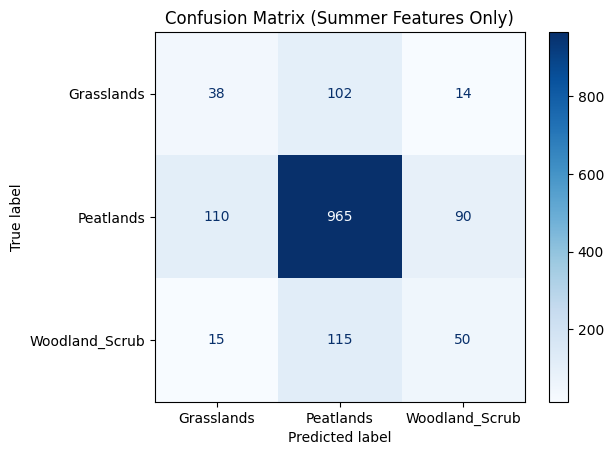

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

print("\n--- Final Multi-Source Seasonal Report (Summer Features Only) ---")
print(classification_report(y_test, rf.predict(X_test)))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf.predict(X_test), labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Summer Features Only)')
plt.show()

Original training set shape: Counter({np.str_('Peatlands'): 2717, np.str_('Woodland_Scrub'): 420, np.str_('Grasslands'): 358})
Resampled training set shape: Counter({np.str_('Woodland_Scrub'): 2717, np.str_('Peatlands'): 2717, np.str_('Grasslands'): 2717})

--- Multi-Source Seasonal Report with SMOTE (Summer Features Only) ---
                precision    recall  f1-score   support

    Grasslands       0.23      0.25      0.24       154
     Peatlands       0.82      0.81      0.82      1165
Woodland_Scrub       0.33      0.34      0.34       180

      accuracy                           0.70      1499
     macro avg       0.46      0.47      0.47      1499
  weighted avg       0.70      0.70      0.70      1499



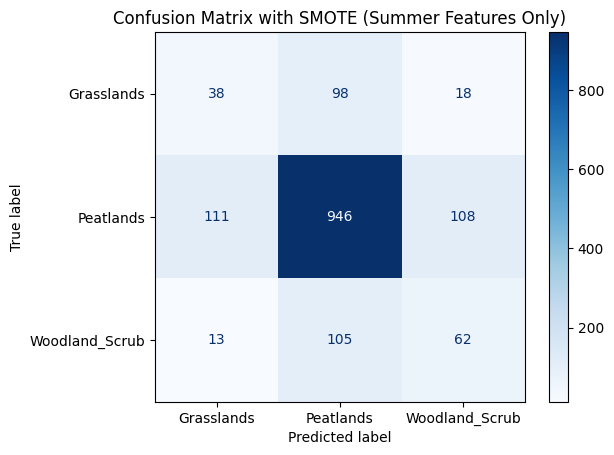

In [60]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print(f"Original training set shape: {Counter(y_train)}")

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

print(f"Resampled training set shape: {Counter(y_resampled)}")

# Retrain the Random Forest Classifier with the resampled data
rf_resampled = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=42)
rf_resampled.fit(X_resampled, y_resampled)

print("\n--- Multi-Source Seasonal Report with SMOTE (Summer Features Only) ---")
print(classification_report(y_test, rf_resampled.predict(X_test)))

# Display the confusion matrix for the resampled model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_resampled = confusion_matrix(y_test, rf_resampled.predict(X_test), labels=rf_resampled.classes_)
disp_resampled = ConfusionMatrixDisplay(confusion_matrix=cm_resampled, display_labels=rf_resampled.classes_)
disp_resampled.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with SMOTE (Summer Features Only)')
plt.show()

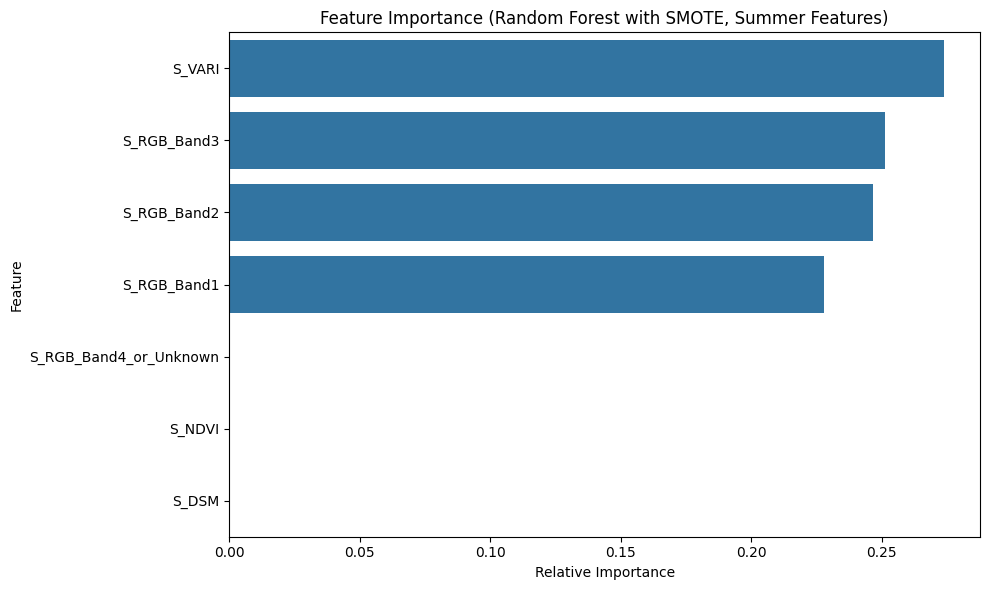

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances from the trained model
importances = rf_resampled.feature_importances_

# Create feature names based on how they were combined in 'combined' array
feature_names = [
    'S_RGB_Band1', 'S_RGB_Band2', 'S_RGB_Band3',
    'S_NDVI',
    'S_VARI',
    'S_DSM'
]

# Check if the number of feature importances matches the expected number of features (7, as X.shape is (..., 7))
# The model trained on 7 features (S_RGB has 3 bands, S_NDVI, S_VARI, S_DSM). Let's adjust feature names to match.
# It seems `combined` was constructed with 6 actual features (3 RGB, 1 NDVI, 1 VARI, 1 DSM).
# Let's verify the number of features that rf_resampled was trained on

num_features_trained = rf_resampled.n_features_in_

# Adjust feature_names to match the number of features in X (X.shape is (5028, 7), so there are 7 features)
# Let's assume the 7th feature is an additional band from s_rgb, which was not explicitly accounted for in the comments
# For now, let's create generic names if the explicit names don't match up to 7
if num_features_trained == 7:
    feature_names = [
        'S_RGB_Band1', 'S_RGB_Band2', 'S_RGB_Band3', 'S_RGB_Band4_or_Unknown',
        'S_NDVI',
        'S_VARI',
        'S_DSM'
    ]
elif num_features_trained == 6:
    feature_names = [
        'S_RGB_Band1', 'S_RGB_Band2', 'S_RGB_Band3',
        'S_NDVI',
        'S_VARI',
        'S_DSM'
    ]
else:
    feature_names = [f'Feature_{i+1}' for i in range(num_features_trained)]


# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest with SMOTE, Summer Features)')
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [63]:
from collections import Counter

print(f"Samples per class in training set: {Counter(y_train)}")
print(f"Samples per class in testing set:  {Counter(y_test)}")

Samples per class in training set: Counter({np.str_('Peatlands'): 2717, np.str_('Woodland_Scrub'): 420, np.str_('Grasslands'): 358})
Samples per class in testing set:  Counter({np.str_('Peatlands'): 1165, np.str_('Woodland_Scrub'): 180, np.str_('Grasslands'): 154})


In [64]:
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(sampling_strategy='all', replacement=True)
brf.fit(X_train, y_train)

BalancedRandomForestClassifier()


--- Balanced Random Forest Classifier Report ---
                precision    recall  f1-score   support

    Grasslands       0.22      0.48      0.30       154
     Peatlands       0.86      0.58      0.69      1165
Woodland_Scrub       0.25      0.53      0.34       180

      accuracy                           0.56      1499
     macro avg       0.44      0.53      0.44      1499
  weighted avg       0.72      0.56      0.61      1499



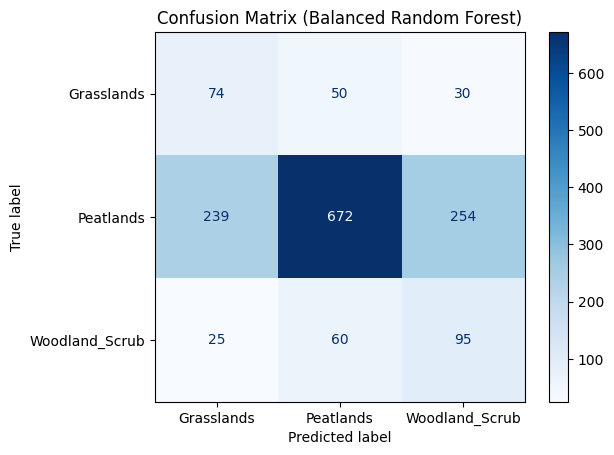

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n--- Balanced Random Forest Classifier Report ---")
print(classification_report(y_test, brf.predict(X_test)))

cm_brf = confusion_matrix(y_test, brf.predict(X_test), labels=brf.classes_)
disp_brf = ConfusionMatrixDisplay(confusion_matrix=cm_brf, display_labels=brf.classes_)
disp_brf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Balanced Random Forest)')
plt.show()

In [68]:
# Instead of equalizing everyone to ~300,
# allow Peatlands to keep a larger presence.
sampling_strategy = {
    'Peatlands': 1000,   # Keep more of the majority to reduce false positives
    'Woodland_Scrub': 420,
    'Grasslands': 358
}

brf = BalancedRandomForestClassifier(sampling_strategy=sampling_strategy, random_state=42)

In [69]:
# 1. Train the model
brf.fit(X_train, y_train)

# 2. Make new predictions
y_pred_new = brf.predict(X_test)

# 3. Check if Precision improved
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_new))

                precision    recall  f1-score   support

    Grasslands       0.26      0.29      0.27       154
     Peatlands       0.83      0.80      0.81      1165
Woodland_Scrub       0.34      0.38      0.36       180

      accuracy                           0.70      1499
     macro avg       0.48      0.49      0.48      1499
  weighted avg       0.71      0.70      0.70      1499



In [70]:
sampling_strategy = {
    'Peatlands': 700,  # Try a middle ground between 350 and 1000
    'Woodland_Scrub': 420,
    'Grasslands': 358
}

In [71]:
# 1. Train the model
brf.fit(X_train, y_train)

# 2. Make new predictions
y_pred_new = brf.predict(X_test)

# 3. Check if Precision improved
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_new))

                precision    recall  f1-score   support

    Grasslands       0.26      0.29      0.27       154
     Peatlands       0.83      0.80      0.81      1165
Woodland_Scrub       0.34      0.38      0.36       180

      accuracy                           0.70      1499
     macro avg       0.48      0.49      0.48      1499
  weighted avg       0.71      0.70      0.70      1499

